# One-way anova

Imagine you have three
groups, and you want to do a one-level ANOVA to test for overall
differences across the groups.

The general technique for a permutation test is:

* You decide on your metric
* You get your metric for the actual data - observed metric
* You permute your data and take the same metric from the permuted
data, and repeat many times - fake metrics
* You compare your observed metric to your fake metrics, to see how
unusual it is.

So for a two-sample permutation test, your metric is the difference in
the two sample means.

For a three sample version of the test - we need a metric that will be
big where there are big differences between the three groups, and
small when there are small differences.

One good metric could be to:

Get the sample means for each of the three groups A, B, C, to give
mean_a, mean_b, nean_c

Get the mean across all the observations regardless of group (mean_overall)

Subtract mean_overall from each of mean_a, mean_b, mean_c to give
mean_a_diff, mean_b_diff, mean_c_diff

As usual, we need one number as our metric, and as usual, we're
interested in positive as well as negative differences, so we want to
get rid of the signs on these somehow, before adding them up.  One way
is to square them, and so the metric is:

our_metric = mean_a_diff ** 2 + mean_b_diff ** 2 + mean_c_diff ** 2

This will be big when the individual groups have different means from
each other and small when the means for the groups are pretty similar
to each other, and therefore, to the overall mean.

So - just follow the recipe - calculate this metric for the actual
groups A, B, C.   Permute the group labels to give random groups A, B,
C, and recalculate the metric.   See whether the metric in the real
data is unusual in the distribution of the same metric for the
permuted groups.

This is the permutation equivalent of the one-way ANOVA.   The one-way
ANOVA just uses some assumptions from the normal distribution to
estimate the random distribution, instead of using permutation to
calculate the random distribution.


Dataset from <https://dasl.datadescription.com/datafile/contrast-baths>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
baths = pd.read_csv('contrast-baths.txt', sep='\t')
baths.head()

,Treatment,Hand Vol Chg
0,Bath,10
1,Exercise,0
2,Bath,10
3,Bath,5
4,Bath,


In [5]:
baths.dtypes

Treatment       object
Hand Vol Chg    object
dtype: object

In [10]:
baths['Hand Vol Chg'] = baths['Hand Vol Chg'].replace(' ', '')
baths['Hand Vol Chg'] = pd.to_numeric(baths['Hand Vol Chg'])
baths.head()

,Treatment,Hand Vol Chg
0,Bath,10.0
1,Exercise,0.0
2,Bath,10.0
3,Bath,5.0
4,Bath,NaN


In [11]:
baths_clean = baths.dropna()
baths_clean.head()

,Treatment,Hand Vol Chg
0,Bath,10.0
1,Exercise,0.0
2,Bath,10.0
3,Bath,5.0
5,Exercise,4.0


<AxesSubplot:xlabel='Treatment', ylabel='Hand Vol Chg'>

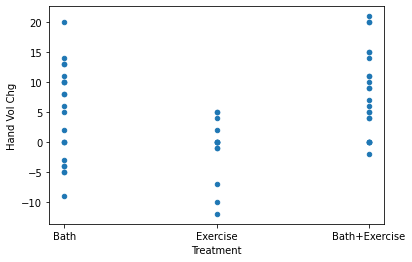

In [13]:
baths_clean.plot.scatter('Treatment', 'Hand Vol Chg')

In [14]:
means = baths_clean.groupby('Treatment').mean()
means

,Hand Vol Chg
Treatment,
Bath,4.545455
Bath+Exercise,8.000000
Exercise,-1.071429


In [19]:
overall_mean = np.mean(baths_clean['Hand Vol Chg'])
overall_mean

4.559322033898305

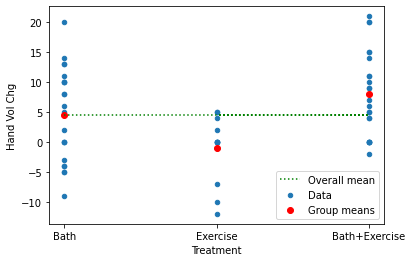

In [25]:
baths_clean.plot.scatter('Treatment', 'Hand Vol Chg',
                         label='Data')
plt.scatter(means.index, np.array(means), color='red',
            label='Group means')
plt.plot(means.index, [overall_mean, overall_mean, overall_mean],
         ':', color='green',
         label='Overall mean')
plt.legend();

In [26]:
mean_diffs = means - overall_mean
mean_diffs

,Hand Vol Chg
Treatment,
Bath,-0.013867
Bath+Exercise,3.440678
Exercise,-5.630751


In [27]:
mean_diff_ssq = np.sum(mean_diffs ** 2)
mean_diff_ssq

Hand Vol Chg    43.54381
dtype: float64

In [28]:
n = len(baths_clean)
n

59

In [32]:
fake_data = baths_clean.copy()
# Permute the treatment labels
fake_data['Treatment'] = np.random.permutation(fake_data['Treatment'])
fake_data.head()

,Treatment,Hand Vol Chg
0,Bath+Exercise,10.0
1,Bath+Exercise,0.0
2,Bath+Exercise,10.0
3,Exercise,5.0
5,Bath,4.0


In [33]:
fake_means = fake_data.groupby('Treatment').mean()
fake_means

,Hand Vol Chg
Treatment,
Bath,7.727273
Bath+Exercise,3.521739
Exercise,1.285714


In [36]:
# The overall mean cannot change, because we're putting in the same
# set of numbers, perhaps in a different order.
np.mean(fake_data['Hand Vol Chg']) == overall_mean

True

In [37]:
fake_ssq = np.sum((fake_means - overall_mean) ** 2)
fake_ssq

Hand Vol Chg    21.828998
dtype: float64

In [38]:
def ssq_mean_diffs(df, group_col, val_col):
    overall_mean = np.mean(df[val_col])
    group_means = df.groupby(group_col)[val_col].mean()
    return np.sum((group_means - overall_mean) ** 2)

In [41]:
ssq_mean_diffs(baths_clean, 'Treatment', 'Hand Vol Chg')

43.54380955304242

In [42]:
ssq_mean_diffs(fake_data, 'Treatment', 'Hand Vol Chg')

21.828997566181727

In [43]:
n_iters = 10000
fake_ssqs = np.zeros(n_iters)
for i in np.arange(n_iters):
    fake_data['Treatment'] = np.random.permutation(fake_data['Treatment'])
    fake_ssqs[i] = ssq_mean_diffs(fake_data, 'Treatment', 'Hand Vol Chg')

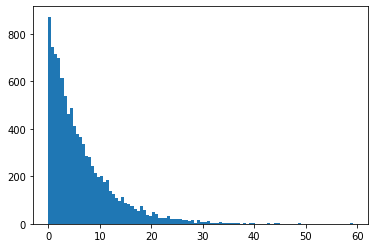

In [45]:
plt.hist(fake_ssqs, bins=100);

In [47]:
p = np.count_nonzero(fake_ssqs >= float(mean_diff_ssq)) / n_iters
p

0.0013

Notice the all-but-identical value from the standard one-way ANOVA F-test:

In [51]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols('Q("Hand Vol Chg") ~ Treatment', data=baths_clean).fit()

sm.stats.anova_lm(mod, typ=1) 

,df,sum_sq,mean_sq,F,PR(>F)
Treatment,2.0,716.159256,358.079628,7.4148,0.001391
Residual,56.0,2704.383117,48.292556,NaN,NaN


Or:

In [52]:
from scipy.stats import f_oneway

In [53]:
treatment = baths_clean['Treatment']
change = baths_clean['Hand Vol Chg']
bath = change[treatment == 'Bath']
both = change[treatment == 'Bath+Exercise']
exercise = change[treatment == 'Exercise']
f_oneway(bath, both, exercise)

F_onewayResult(statistic=7.414799716344096, pvalue=0.0013907554044090167)

Thinking of the residual variances:

In [60]:
bath_resid = bath - np.mean(bath)
both_resid = both - np.mean(both)
ex_resid = exercise - np.mean(exercise)
# Stick these all together into one array
all_group_resids = np.concatenate([bath_resid, both_resid, ex_resid])
ssq_groups = np.sum(all_group_resids ** 2)
ssq_groups

2704.3831168831166

In [61]:
ssq_overall = np.sum((change - overall_mean) ** 2)
ssq_overall

3420.542372881356

In [95]:
F = ((ssq_overall - ssq_groups) / 2) / (ssq_groups / (n - 3))
F

7.414799716344101

In [98]:
(ssq_overall - ssq_groups) / 2 

358.0796279991198

In [100]:
top = ssq_mean_diffs(baths_clean, 'Treatment', 'Hand Vol Chg')

In [101]:
x = top / F
x

5.872553705943104

48.29255565862708